In [1]:
import pandas as pd
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc
from colormath.color_conversions import convert_color
from colormath.color_objects import LabColor, sRGBColor
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# 실제 Lab 값과 예측한 Lab 값 사이의 cmc dE를 반환하는 함수
def color_diff(PRED_COLOR, REAL_COLOR):
    # PRED_COLOR는 예측한 [L,a,b] 값으로 이루어진 데이터 프레임
    # REAL_COLOR는 실제 [L,a,b] 값으로 이루어진 데이터 프레임
    diff = []
    for i in REAL_COLOR.index:
        pred = PRED_COLOR.loc[i]
        true = REAL_COLOR.loc[i]
        p_lab = LabColor(pred[0],pred[1],pred[2]) # Colormath_LabColor 값으로 변환
        t_lab = LabColor(true[0],true[1],true[2]) # Colormath_LabColor 값으로 변환
        delta = delta_e_cmc(p_lab, t_lab) # Colormath의 delta_e_cmc로 색차 계산
        diff.append(delta) 
    diff = pd.DataFrame(diff)
    diff.index = REAL_COLOR.index
    return(diff) 

In [3]:
# 색상 시각화를 위해 Lab 값을 RGB로 변환하는 함수
# data는 각 샘플별 L, a, b 값
def lab_to_rgb(data):
    R, G, B=[], [], []
    for i in range(len(data)):
        lab = LabColor(data.iloc[i, 0],
                     data.iloc[i, 1],
                     data.iloc[i, 2], observer='10', illuminant='d65')
                                # 10도 시야각에서 d65 광원으로 관측한 색상 값
        rgb = convert_color(lab, sRGBColor, target_illuminant='d65')
        upscaled_rgb = sRGBColor(
            rgb.clamped_rgb_r, rgb.clamped_rgb_g, rgb.clamped_rgb_b
        ).get_upscaled_value_tuple()

        R.append(upscaled_rgb[0])
        G.append(upscaled_rgb[1])
        B.append(upscaled_rgb[2])

    df = pd.DataFrame({'r' : R, 'g' : G, 'b' : B})
    df.index=data.index
    return(df)

In [4]:
# 색상 이미지 플롯 함수 
# n : 색상을 표현하고자 하는 샘플의 인덱스
# df_real : 실제 색상의 rgb로 이루어진 데이터프레임
# df_pred : 예측 색상의 rgb로 이루어진 데이터프레임

def showcolor(n, df_real, df_pred, df_deltaE):
    plt.figure(figsize=(4,2))
    # 실제 컬러
    plt.subplot(121)
    plt.imshow(Image.new("RGB", (50,50),
                         (df_real['r'][n], df_real['g'][n], df_real['b'][n])))
    plt.title('Index: ' + str(n) + '\nReal Color')
    plt.xticks([])
    plt.yticks([])

    # 예측 컬러
    plt.subplot(122)
    plt.imshow(Image.new("RGB", (50,50),
                         (df_pred['r'][n], df_pred['g'][n], df_pred['b'][n])))
    plt.title('ΔE: ' + str(df_deltaE.iloc[n,0]) + '\nPred Color')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(str(n)+'.png')
    plt.show()

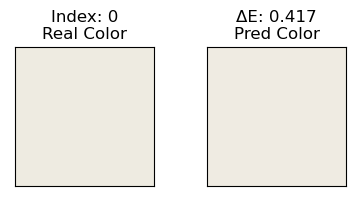

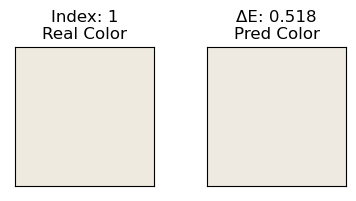

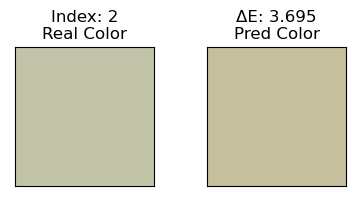

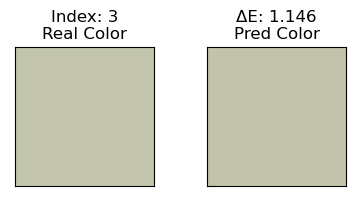

In [6]:
# 사용 예시입니다.
# 다음과 같이 예측 Lab와 실제 Lab가 있을 때,
pred_lab = pd.DataFrame({
    'l':[93.28527357,92.91671812, 77.24069409, 78.19580113,],
    'a':[0.15604233,0.08811366, -3.89298651, -3.83741976],
    'b':[3.91453314, 3.88917526, 16.9964169, 11.45915211]
})

real_lab = pd.DataFrame({
    'L':[92.95, 92.61,78.31, 78.65],
    'A':[-0.05, 0.05 ,-5.02, -4.92],
    'B':[4.17, 4.33 ,12.22, 11.60]
})

## 1.색차 추출
delta_e = color_diff(PRED_COLOR=pred_lab, REAL_COLOR=real_lab)
delta_e.columns=['cmc_delta_e']
delta_e = delta_e.round(3)

## 2.real_lab를 rgb로 변환
real_rgb = lab_to_rgb(real_lab)

## 3.pred_lab를 rgb로 변환
pred_rgb = lab_to_rgb(pred_lab)

## 4. 1~3을 이용하여 색상 표현과 색차 명시
for N in range(len(real_rgb)):
    showcolor(n=N, df_real=real_rgb, df_pred=pred_rgb, df_deltaE=delta_e)